In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import pandas as pd
import pickle as pkl
import urllib
import tarfile

from astropy.io import fits
from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from astropy.convolution import convolve
from astroquery.mast import Observations
from glob import glob
from lmfit import Model
from lmfit.printfuncs import report_fit
from pathlib import Path
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from specutils.manipulation import LinearInterpolatedResampler
from specutils import Spectrum1D

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [119]:
# Load in RU Lupi data
spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))
#spectrum_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))
#spectrum_files = glob(os.path.join('HST','anonymous37222', '*.fits'))

In [122]:
spec = Table.read(spectrum_files[0])
spec['WAVELENGTH'][spec['SEGMENT']=='FUVA'].min()

np.float64(1277.973751578046)

In [ ]:
INST_head = [fits.getheader(file, ext=0) for file in spectrum_files]
SCI_head = [fits.getheader(file, ext=1) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [ ]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv
lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)

In [ ]:
file_idx = 5
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.ravel(spectrum_x1d[file_idx]['WAVELENGTH'])
x1d_flux = np.ravel(spectrum_x1d[file_idx]['FLUX'])
x1d_fluxerr = np.ravel(spectrum_x1d[file_idx]['ERROR'])

In [ ]:
peaks , _ = find_peaks(np.array(x1d_flux), height=max(x1d_fluxerr.value)*2, distance=100)
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

## Fetch COS LSF and Dispersion files

In [ ]:
#errors out for 230L files which we aren't using anyway
datadir = 'HST/'
def fetch_COSfiles(grating, lpPos, cenwave, disptab):

    """
    Given all the inputs: (detector, grating, LP-POS, cenwave, dispersion table,) this will download both
    the LSF file and Disptab file you should use in the convolution and return their paths.
    Returns:
    LSF_file_name (str): filename of the new downloaded LSF file
    disptab_path (str): path to the new downloaded disptab file
    """
    COS_site_rootname = (
        "https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/"
        "performance/spectral-resolution/_documents/"
    )  # Link to where all the files live - split into 2 lines
    LSF_file_name = f"aa_LSFTable_{grating}_{cenwave}_LP{lpPos}_cn.dat"

    LSF_file_webpath = COS_site_rootname + LSF_file_name  # Where to find file online
    lsffileSave = datadir+LSF_file_name
    lsfpathObj = Path(lsffileSave)
    if not lsfpathObj.is_file():
        try:
            urllib.request.urlretrieve(
                LSF_file_webpath, lsffileSave
            )  # Where to save file to locally
            print(f"Downloaded LSF file to {lsffileSave}")
        except urllib.error.HTTPError:
            print(f'404 error for {lsffileSave}')
    else:
        print(f'File already exists, skipping {lsffileSave}')

    # And we'll need to get the DISPTAB file as well
    disptab_path = datadir + disptab
    disptabpathObj = Path(disptab_path)
    if not disptabpathObj.is_file():
        try:
            urllib.request.urlretrieve(
                f"https://hst-crds.stsci.edu/unchecked_get/references/hst/{disptab}",
                disptab_path,
            )
            print(f"Downloaded DISPTAB file to {disptab_path}")
        except urllib.error.HTTPError:
            print(f'404 error for {disptab_path}')
    else:
        print(f'File already exists, skipping {disptab_path}')
    return LSF_file_name, disptab_path

# Do this for every file, just keep the line centers though. Making it a function

In [2]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
clrs = sns.color_palette('Set1')
clrs[5] = (255/255, 200/255, 80/255)
colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=False)

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
plt.rcParams['figure.dpi'] = 75

In [19]:
#Keep units for future math
def make_spectrum(row):
    spectrum = Spectrum1D(flux = row['flux'], spectral_axis=row['wavelength'], uncertainty=StdDevUncertainty(row['fluxerr']))
    #spectrum.spectral_axis.to(u.km/u.s, doppler_convention='optical', doppler_rest=row['labline']*u.AA)
    return spectrum

def read_lsf(filename):
    # This is the table of all the LSFs: called "lsf"
    # The first column is a list of the wavelengths corresponding to the line profile, so we set our header accordingly
    hs = 0
    lsf = Table.read(filename, format="ascii", header_start=hs)

    # This is the range of each LSF in pixels (for FUV from -160 to +160, inclusive)
    # middle pixel of the lsf is considered zero ; center is relative zero
    pix = np.arange(len(lsf)) - len(lsf) // 2  # integer division to yield whole pixels

    # the column names returned as integers.
    lsf_wvlns = np.array([int(float(k)) for k in lsf.keys()])

    return lsf, pix, lsf_wvlns

def get_asnfilenames(fuvFile, datadir):
    """
    A function to fetch the right association filenames for convolution based on fits header information

    Parameters:
    fuvFile: a FITS HDU file with a SCI header
    datadir: the directory in which the association files are stored

    Returns:
    disptab_file (str): the name of the associated dispersion table file
    lsf_file (str): the name of the associated line spread function file based on 
                    filter, lifetime position, and central wavelength
    """
    fuvHeader0 = fits.getheader(fuvFile, ext=0)

    disptab_file = fuvHeader0['DISPTAB'].split("$")[1]
    grating = fuvHeader0['OPT_ELEM']
    cenwave = fuvHeader0['CENWAVE']
    lpPos = fuvHeader0['LIFE_ADJ']
    lsf_file = os.path.join(datadir,f"aa_LSFTable_{grating}_{cenwave}_LP{lpPos}_cn.dat")
    disptab_file = os.path.join(datadir,disptab_file)
    return lsf_file, disptab_file
    
def get_disp_params(disptab, cenwave, filter, segment):
    """
    Helper function to redefine_lsf(). Reads through a DISPTAB file and gives relevant\
    dispersion relationship/wavelength solution over input pixels.
    Parameters:
    disptab (str): Path to your DISPTAB file.
    cenwave (str): Cenwave for calculation of dispersion relationship.
    segment (str): FUVA or FUVB?

    Returns:
    disp_coeff (list): Coefficients of the relevant polynomial dispersion relationship
    wavelength (list; if applicable): Wavelengths corresponding to input x pixels 
    """
    with fits.open(disptab, ignore_missing_simple=True) as d:
        wh_disp = np.where(
            (d[1].data["cenwave"] == cenwave)
            & ((d[1].data["segment"] == segment) if segment is not None else True)
            & (d[1].data["OPT_ELEM"] == filter)
            & (d[1].data["aperture"] == "PSA")
        )[0]
        disp_coeff = d[1].data[wh_disp]["COEFF"][0] # 0 is needed as this returns nested list [[arr]]
        d_tv03 = d[1].data[wh_disp]["D_TV03"]  # Offset from WCA to PSA in Thermal Vac. 2003 data
        d_orbit = d[1].data[wh_disp]["D"]  # Current offset from WCA to PSA

    delta_d = d_tv03 - d_orbit
    disp_coeff = disp_coeff-delta_d
    #wavelength = np.polyval(p=disp_coeff[::-1], x=np.arange(16384))
    return disp_coeff
    
def redefine_lsf(lsf_file, disptab, cenwave, filter, segment):
    """
    Helper function to convolve_lsf(). Converts the LSF kernels in the LSF file from a fn(pixel) -> fn(λ)\
    which can then be used by convolve_lsf() and re-bins the kernels.
    Parameters:
    lsf_file (str): path to your LSF file
    cenwave (str): Cenwave for calculation of dispersion relationship
    disptab (str): path to your DISPTAB file
    
    Returns:
    new_lsf (numpy.ndarray): Remapped LSF kernels.
    new_w (numpy.ndarray): New LSF kernel's LSF wavelengths.
    step (float): first order coefficient of the FUVA dispersion relationship; proxy for Δλ/Δpixel.
    """

    # Read in the dispersion relationship here for the segments
    if segment == 'FUVB':
        if (cenwave != 1105) & (cenwave != 800):
            disp_coeff = get_disp_params(disptab, cenwave, filter, segment)
    else:
        disp_coeff = get_disp_params(disptab, cenwave, filter, segment)

    # Get the step size info from the FUVA 1st order dispersion coefficient
    step = disp_coeff[1]

    # Read in the lsf file
    lsf, pix, w = read_lsf(lsf_file)

    # take median spacing between original LSF kernels
    deltaw = np.median(np.diff(w))

    if (deltaw < len(pix) * step * 2):  # resamples if the spacing of the original LSF wvlns is too narrow
        # this is all a set up of the bins we want to use
        # The wvln difference between kernels of the new LSF should be about twice their width
        new_deltaw = int(len(pix) * step * 2.0)  
        new_nw = (int(round((max(w) - min(w)) / new_deltaw)) + 1)  # nw = number of LSF wavelengths
        
        new_w = min(w) + np.arange(new_nw) * new_deltaw  # new version of lsf_wvlns
        
        # populating the lsf with the proper bins
        new_lsf = np.zeros((len(pix), new_nw))  # empty 2-D array to populate

        for i, current_w in enumerate(new_w):
            dist = abs(current_w - w)  # Find closest original LSF wavelength to new LSF wavelength
            lsf_index = np.argmin(dist)
            orig_lsf_wvln_key = lsf.keys()[lsf_index]  # column name corresponding to closest orig LSF wvln
            new_lsf[:, i] = np.array(lsf[orig_lsf_wvln_key])  # assign new LSF wvln the kernel of the closest original lsf wvln
    else:
        new_lsf = lsf
        new_w = w
    return new_lsf, new_w, step

def convolve_lsf(wavelength, spec, specerr, lsf_file, disptab, cenwave, filter, segment):

    """
    Main function; Convolves an input spectrum - i.e. template or STIS spectrum - with the COS LSF.
    Parameters:
    wavelength (list or array): Wavelengths of the spectrum to convolve.
    spec (list or array): Fluxes or intensities of the spectrum to convolve.
    cenwave (str): Cenwave for calculation of dispersion relationship
    lsf_file (str): Path to your LSF file
    disptab (str): Path to your DISPTAB file
    Returns:
    wave_cos (numpy.ndarray): Wavelengths of convolved spectrum.!Different length from input wvln
    final_spec (numpy.ndarray): New LSF kernel's LSF wavelengths.!Different length from input spec
    """
    # First calls redefine to get right format of LSF kernels
    new_lsf, new_w, step = redefine_lsf(lsf_file, disptab, cenwave, filter, segment)

    # sets up new wavelength scale used in the convolution
    nstep = round((max(wavelength) - min(wavelength)) / step) - 1
    wave_cos = min(wavelength) + np.arange(nstep) * step

    # resampling onto the input spectrum's wavelength scale
    interp_func = interp1d(wavelength, spec)  # builds up interpolated function from input spectrum
    spec_cos = interp_func(wave_cos)  # lower res version of the same input spectrum
    final_spec = interp_func(wave_cos)  # initialize convolution spectrum

    interp_errf = interp1d(wavelength, specerr)
    specerr_cos = interp_errf(wave_cos)
    final_specerr = interp_errf(wave_cos)

    best_kernel_idx = np.argmin(np.abs(new_w-max(spec)))
    current_lsf = new_lsf[:, best_kernel_idx]
    final_spec = convolve(
                    spec_cos,
                    current_lsf,  # Applies the actual convolution
                    boundary="extend",
                    normalize_kernel=True,
                )
    final_specerr = convolve(
                    specerr_cos,
                    current_lsf,  # Applies the actual convolution
                    boundary="extend",
                    normalize_kernel=True,
                )
    #one final interpolation to make arrays the same length as the input arrays
    xnew = np.linspace(min(wave_cos), max(wave_cos), len(wavelength))
    final_interpfunc = interp1d(wave_cos, final_spec)
    final_interperrfunc = interp1d(wave_cos, final_specerr)
    
    conv_spec = final_interpfunc(xnew)
    conv_specerr = final_interperrfunc(xnew)
    return xnew, conv_spec, conv_specerr

def gaussian(x, amp, sig, cen, bgl):
    y = amp * np.exp(-((x - cen)**2.0)/(2.0 * (sig**2.0))) + bgl
    return y

def double_gauss(x, amp1, sig1, cen1, amp2, sig2, cen2, bgl):
    y = gaussian(x, amp1, sig1, cen1, bgl) + gaussian(x, amp2, sig2, cen2, bgl)
    return y

def d_test(mu1, mu2, sigma):
    d = np.abs(mu1-mu2)/2*sigma
    return d <= 1

def mask_contamination(labline,  mask_dict):
    mask_idx = mask_dict[labline]
    if isinstance(mask_idx, list):
        mask=np.ones(300, dtype=bool)
        mask[mask_idx[0]:mask_idx[1]] = False
        return mask
    else:
        mask=np.zeros(300, dtype=bool)
        mask[mask_idx:] = True
        return mask

lineModel = Model(gaussian)
def fit_oneGauss(df, mask_dict):
    fit_keys = lineModel.param_names
    df['BIC1'] = pd.Series([None] * len(df), dtype=object)
    df['params1'] = pd.Series([None] * len(df), dtype=object)

    for i, row in df.iterrows():

        flux = row['flux'].to_value(all_spectra.flux_units)
        wavelength = row['wavelength'].to_value(all_spectra.wavelength_units)
        fluxerr = row['fluxerr'].to_value(all_spectra.flux_units)
        ############
        #mask the spurious lines in each unique progression, labline combo
        labline = row['labline']
        x = wavelength.copy()
        y = flux.copy()
        yerr = fluxerr.copy()
        
        if labline in mask_dict.keys():
            mask = mask_contamination(labline,  mask_dict)
            #x[mask], y[mask], yerr[mask] = np.nan, np.nan, 1e-24
            x = x[~mask]
            y = y[~mask]
            yerr = yerr[~mask]
        peak_idx = np.argmax(y)
        peak = y[peak_idx]
        cen = x[peak_idx]
        bgl = np.median(y[0:10])
        #single gaussian fit
        lineParam = lineModel.make_params(amp=peak,
                                        sig=1,
                                        cen=cen,
                                        bgl=bgl
                                        )
        
        lineParam['amp'].set(min=0.9*peak, max=peak*10)
        lineParam['sig'].set(min=0.0, max=3)
        lineParam['cen'].set(min=np.min(x), max=lineParam['cen']+2)
        lineParam['bgl'].set(min=bgl*0.8, max=1e-10)

        lineFit = lineModel.fit(y, 
                                lineParam, 
                                x=x, 
                                weights=1/yerr,
                                scale_covar=True,
                                nan_policy='omit'
                                )
        #report_fit(lineFit)
        bestParam = lineFit.params
        param_dict = {param:[bestParam[param].value, bestParam[param].stderr] for param in fit_keys}
        param_dict['wavelength'] = x*all_spectra.wavelength_units
        param_dict['velocity'] = all_spectra.radial_velocity(x*all_spectra.wavelength_units, row['labline'])
        df.at[i, 'BIC1'] = lineFit.bic
        df.at[i, 'params1'] = param_dict

doubleLineModel = Model(double_gauss)
def fit_twoGauss(df, mask_dict):
    fit_keys = doubleLineModel.param_names
    df['BIC2'] = pd.Series([None] * len(df), dtype=object)
    df['params2'] = pd.Series([None] * len(df), dtype=object)
    for i, row in df.iterrows():
        flux = row['flux'].value
        wavelength = row['wavelength'].value
        fluxerr = row['fluxerr'].value
        
        ############
        #mask the spurious lines in each unique progression, labline combo
        labline = row['labline']
        x = wavelength.copy()
        y = flux.copy()
        yerr = fluxerr.copy()
        bestPar = np.array(list(row['params1'].values())[:-2])[:,0]
        if labline in mask_dict.keys():
            mask = mask_contamination(labline,  mask_dict)
            #x[mask], y[mask], yerr[mask] = np.nan, np.nan, 1e-24
            x = x[~mask]
            y = y[~mask]
            yerr = yerr[~mask]
        #double gaussian fit. Uses the single gauss as the initial guess to test whether a second peak is necessary.
        #additional test on top of the bic
        doubleLineParam = doubleLineModel.make_params(amp1=bestPar[0],
                                                    sig1=bestPar[1], 
                                                    cen1=bestPar[2],
                                                    amp2=bestPar[0]*0.3, 
                                                    sig2=bestPar[1], 
                                                    cen2=bestPar[2]-1, 
                                                    bgl = bestPar[3]
                                                    )
        doubleLineParam['amp1'].set(min=0.8*doubleLineParam['amp1'].value, max=10*doubleLineParam['amp1'].value)
        doubleLineParam['amp2'].set(min=0.0, max=10*doubleLineParam['amp1'].value) #just need amp2 to be smaller
        doubleLineParam['sig1'].set(min=0.0, max=3*doubleLineParam['sig1'].value)
        doubleLineParam['sig2'].set(min=0.0, max=3*doubleLineParam['sig1'].value)
        doubleLineParam['cen1'].set(min=doubleLineParam['cen1'].value-20, max=doubleLineParam['cen1'].value+20)
        doubleLineParam['cen2'].set(min=doubleLineParam['cen1'].value-100, max=doubleLineParam['cen1'].value) #expected to be blue
        #doubleLineParam['bgl'].set(min=0.8*doubleLineParam['bgl'], max=2e-13)
        doubleFit = doubleLineModel.fit(y,
                                        doubleLineParam,
                                        x=x,
                                        weights=1/yerr,
                                        scale_covar=False,
                                        )
        best2par = doubleFit.params
        print([best2par[param].stderr for param in fit_keys])
        param_dict = {param:[best2par[param].value, best2par[param].stderr] for param in fit_keys}
        param_dict['wavelength'] = x*all_spectra.wavelength_units
        param_dict['velocity'] = all_spectra.radial_velocity(x*all_spectra.wavelength_units, row['labline'])
        df.at[i, 'BIC2'] = doubleFit.bic
        df.at[i, 'params2'] = param_dict

def gauss_err(params):
    model_items = list(params.items())[:-2]
    par = np.array([v[0] for _, v in model_items])
    errs = np.array([v[1] for _, v in model_items])
    params_lower = par - errs
    params_upper = par + errs
    flux_upper = gaussian(params['wavelength'].value, *params_upper)
    flux_lower = gaussian(params['wavelength'].value, *params_lower)
    specerr = (flux_upper - flux_lower) / 2
    return specerr

def double_gauss_err(params):
    model_items = list(params.items())[:-2]
    par = np.array([v[0] for _, v in model_items])
    errs = np.array([v[1] for _, v in model_items])
    params_lower = par - errs
    params_upper = par + errs
    flux_upper = double_gauss(params['wavelength'].value, *params_upper)
    flux_lower = double_gauss(params['wavelength'].value, *params_lower)
    specerr = (flux_upper - flux_lower) / 2
    return specerr

class spectrum():
    def __init__(self, files, linelist_file, dataDir, convolve=False):
    
        """
        Initialize spectrum, unpack spectra into useable arrays
        
        Parameters:
        - files: a list of .fits files from HST, each with a header hdu, and a spectrum BinTable hdu
        """
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**2)))
        self.wavelength_units = u.AA
        self.linelist = None
        self.linelist = pd.read_csv(linelist_file, skiprows=2)
        #construct dataframe with filename, relevant header information, and spectrum information for each file.
        #Then add to a list of dataframes from files
        rows = []
    
        for file in files:
            #Use np.ravel here because the wavelength in the table  is a list in one table cell (e.g. [[1, 2, 3]])
            INST_head = fits.getheader(file, ext=0)
            SCI_head = fits.getheader(file, ext=1)
            spectrum_x1d = Table.read(file, hdu=1)

            LSF_file, disptab_file = get_asnfilenames(fuvFile=file, datadir=dataDir)
            cenwave = INST_head['CENWAVE']

            if "cspec" in file:
                date = SCI_head['DATE-BEG'][:10]
                segments = None
            elif "x1dsum" in file:
                date = SCI_head['DATE-OBS'] 
                instrument = INST_head['INSTRUME']
                if len(spectrum_x1d['WAVELENGTH']):
                    segmenta = [spectrum_x1d['WAVELENGTH'][spectrum_x1d['SEGMENT']=='FUVA'].min(), spectrum_x1d['WAVELENGTH'][spectrum_x1d['SEGMENT']=='FUVA'].max()]
                    segmentb = [spectrum_x1d['WAVELENGTH'][spectrum_x1d['SEGMENT']=='FUVB'].min(), spectrum_x1d['WAVELENGTH'][spectrum_x1d['SEGMENT']=='FUVB'].max()]
                    segments = [segmenta, segmentb]
                else:
                    segments = None
            try:
                instrument_filter = INST_head['OPT_ELEM']
            except KeyError:
                instrument_filter = INST_head['GRATING'] #in cspec header

            x1d_wavelength = np.ravel(spectrum_x1d['WAVELENGTH'])/self.wavelength_units
            x1d_flux = np.ravel(spectrum_x1d['FLUX'])/self.flux_units
            x1d_fluxerr = np.ravel(spectrum_x1d['ERROR'])/self.flux_units
            self.fileInfo_keys = ['filename', 'obsdate', 'instrument', 'filter', 'dispfile', 'LSFfile', 'cenwave']
            self.specInfo_keys = ['wavelength', 'flux', 'fluxerr', 'velocity', 'segment']
            self.lineInfo_keys = ['H2line_idx', "labline", "transition_prob"]
            df_data = {'filename':file, 
                    'obsdate':date,
                    'instrument':instrument, 
                    'filter':instrument_filter,
                    'dispfile':disptab_file,
                    'LSFfile': LSF_file,
                    'cenwave':cenwave,
                    'wavelength':x1d_wavelength*self.wavelength_units, 
                    'flux': x1d_flux*self.flux_units, 
                    'fluxerr':x1d_fluxerr*self.flux_units,
                    'segment': segments}
            rows.append(pd.Series(df_data))
            
        self.spec_df = pd.DataFrame(rows)
        drop_idx = []
        for i in range(len(self.spec_df)-1):
            if len(self.spec_df.iloc[i]['wavelength'])<1:
                drop_idx.append(i)
        self.spec_df.drop(labels=drop_idx, inplace=True)
        self.spec_df.reset_index(drop=True, inplace=True)
        self.spec_df['obsdate'] = self.spec_df['obsdate'].astype(str)
    
    def mask_df(self, df, mask_dict):
        columns = mask_dict.keys()
        values = mask_dict.values()
        mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, values)])
        filtered = df[mask]
        return filtered

    def coaddwave(self, df, columns=['obsdate']):
        """
        Co-add spectra using the spectrum1D function.

        Parameters:
        - df: The dataframe to use for co-adding. Must contain 'wavelength', 
              'flux', and 'fluxerr' columns at least. If using velocity_space, must contain 'rest_wavelength' column.
        - columns: the columns of unique combinations to apply coadding to.

        Returns:
        - coadded_spectrum: spectrum dataframe
        """

        drop_indices = []
        combinations = df[columns].drop_duplicates()
        for _, row in combinations.iterrows():
            unique_values = [row[col] for col in columns]

            # Filter the group
            mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
            group = df[mask]

            resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
            wavelengths = group['wavelength'].values
            fluxes = group['flux'].values
            fluxerrs = group['fluxerr'].values
            
            template_axis = wavelengths[0][np.argsort(wavelengths[0])]
            template_flux = fluxes[0][np.argsort(wavelengths[0])]
            template_fluxerr = fluxerrs[0][np.argsort(wavelengths[0])]
            
            coadded = Spectrum1D(
                flux=template_flux,
                spectral_axis=template_axis,
                uncertainty=StdDevUncertainty(template_fluxerr)
            )

            for i in np.arange(0, len(wavelengths)):
                x = wavelengths[i]
                flux = fluxes[i]
                err = fluxerrs[i]
                sort_idx = np.argsort(x)
                spec = Spectrum1D(spectral_axis=x[sort_idx], 
                                    flux=flux[sort_idx], 
                                    uncertainty=StdDevUncertainty(err[sort_idx])
                                )
                
                spec_resampled = resampler(spec, coadded.spectral_axis)
                coadded += spec_resampled
            
            first_index = group.index[0]
            df.at[first_index, 'wavelength'] = coadded.wavelength
            df.at[first_index, 'flux'] = coadded.flux
            df.at[first_index, 'fluxerr'] = coadded.uncertainty.quantity.to(self.flux_units)
            drop_indices.extend(group.index[1:])
        
        df.drop(drop_indices, inplace=True)
        df.reset_index(inplace=True, drop=True)
        #return stacked_df
    
    def coaddvel(self, df, columns):
        combinations = df[columns].drop_duplicates()
        drop_indices = []
        for _, row in combinations.iterrows():
            unique_values = [row[col] for col in columns]
            # Filter the group
            mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
            group = df[mask]
            
            coadded_flux = 0
            templatev = group['velocity'].iloc[0]
            coadd_error = 0
            
            for _, row in group.iterrows():
                velocity = row['velocity']
                resampled_flux = np.interp(templatev, velocity, row['flux'])
                resampled_fluxerr = np.interp(templatev, velocity, row['fluxerr'])
                coadded_flux += resampled_flux.value
                coadd_error += (resampled_fluxerr.value)**2

            N = len(group)
            coadded_flux = coadded_flux/N
            coadded_error = np.sqrt(coadd_error)/np.sqrt(N)
            first_index = group.index[0]
            #All the first index properties are inherited and the rest is dropped
            df.at[first_index, 'flux'] = coadded_flux*self.flux_units
            df.at[first_index, 'fluxerr'] = coadded_error*self.flux_units
            drop_indices.extend(group.index[1:])

        df.drop(drop_indices, inplace=True)
        df.reset_index(inplace=True, drop=True)
        #return prog_df

    def H2lines_fromspectrum(self, df):
        """
        Get the H2 line peaks from the spectrum, and add the peaks to the spectrum dataframe

        Parameters:
        - linelist: an array of

        Returns:
        - Line peak indices and the associated transitions added to the original dataframe
        """
        df['H2line_idx'] = pd.Series([None] * len(df), dtype=object)
        df["[nu', J']"] = pd.Series([None] * len(df), dtype=object)
        df["labline"] = pd.Series([None] * len(df), dtype=object)
        df["transition_prob"] = pd.Series([None] * len(df), dtype=object)
        for i, row in df.iterrows():            
            #Find the emission lines associated with H2 fluorescence
            emission_table_idx = [] #wavelength array index
            nu_J = [] #transition of line from linelist
            lab_lines = [] #lab wavelength of emission line from linelist
            transition_prob = []

            for il, l in enumerate(self.linelist['lab_lambda'].values):
                wavelength = row['wavelength']/u.AA
                diffs = np.abs(wavelength-l)
                mask = diffs <= 0.2
                if np.any(mask):
                    min_idx = np.argmin(diffs)
                    emission_table_idx.append(min_idx)
                    nu_J.append(self.linelist.loc[il, '[nu\', J\']'])
                    transition_prob.append(self.linelist.loc[il, 'transition_prob'])
                    lab_lines.append(l)
            df.at[i, 'H2line_idx'] = np.array(emission_table_idx)
            df.at[i, "[nu', J']"] = nu_J
            df.at[i, 'labline'] = lab_lines
            df.at[i, 'transition_prob'] = transition_prob
        return df

    def radial_velocity(self, wavelengths, labline):
        velocity = (wavelengths - labline*u.AA)/(labline*u.AA) * const.c.to(u.km/u.s)
        return velocity
    
    def get_lines(self, df):
        line_width = 150 #150 points on either side of the central line
        transitions = set(self.linelist["[nu\', J\']"])
        line_keys = self.fileInfo_keys+self.specInfo_keys+self.lineInfo_keys
        line_dict = {key: [] for key in line_keys}
        line_dict['transition'] = []
        for target_nuJ in transitions:
            for _, row in df.iterrows():
                if target_nuJ in row["[nu', J']"]:
                    nuJ_array = np.atleast_1d(row["[nu', J']"])
                    h2_idx_array = np.atleast_1d(row['H2line_idx'])
                    targ_idx = np.flatnonzero(nuJ_array == target_nuJ)
                    line_idx = h2_idx_array[targ_idx] #the index of the H2 line of interest in every wavelength coadded spectrum

                    for i, l in enumerate(line_idx):
                        start = max(0, l - line_width)
                        end = min(len(row['wavelength']), l + line_width)  
                        #Spectrum information
                        waves = row['wavelength'][start:end]
                        line_dict['wavelength'].append(waves)
                        line_dict['flux'].append(row['flux'][start:end])
                        line_dict['fluxerr'].append(row['fluxerr'][start:end])
                        velocity = self.radial_velocity(waves, row['labline'][targ_idx[i]])
                        line_dict['velocity'].append(velocity)
                        if row['segment']:
                            if row['segment'][0][0] <= row['labline'][targ_idx[i]] <= row['segment'][0][1]:
                                line_dict['segment'].append('FUVA')
                            elif row['segment'][1][0] <= row['labline'][targ_idx[i]] <= row['segment'][1][1]:
                                line_dict['segment'].append('FUVB')
                            else:
                                line_dict['segment'].append(None)
                        # line_dict['velocity'].append(np.nan)
                        #File information
                        for key in self.fileInfo_keys:
                            line_dict[key].append(row[key])
                        #Line information
                        line_dict['transition'].append(target_nuJ)
                        for key in self.lineInfo_keys:    
                            line_dict[key].append(np.array(row[key])[targ_idx[i]])
        line_df = pd.DataFrame(line_dict)
        return line_df

# Initialize spectrum class with HST files
The data is interesting, I don't have older data, and the cspec files are weird.

In [3]:
x1dsum_files = glob(os.path.join('HST', 'anonymous37222', '*x1dsum.fits'))
all_spectra = spectrum(x1dsum_files, linelist_file='HST/emission_lines.csv', dataDir='HST/', convolve=False)
all_spectra.coaddwave(all_spectra.spec_df, columns = ['obsdate', 'filter'])
all_spectra.H2lines_fromspectrum(all_spectra.spec_df)

,filename,obsdate,instrument,filter,dispfile,LSFfile,cenwave,wavelength,flux,fluxerr,segment,H2line_idx,"[nu', J']",labline,transition_prob
0,HST/anonymous37222/leit1f030_x1dsum.fits,2021-08-13,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1589_LP4_cn.dat,1589,"[1385.9931276253203 Angstrom, 1386.00536736705...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[[1574.1758709162705, 1774.8277413948108], [13...","[19173, 19752, 2397, 10087, 19635, 2634, 10457...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ...","[0.139, 0.125, 0.037, 0.023, 0.092, 0.05, 0.05..."
1,HST/anonymous37222/leit1c040_x1dsum.fits,2021-08-10,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.254196584923 Angstrom, 1421.266445181324...","[4.736898099985594e-15 erg / (Angstrom s cm2),...","[5.222956335908761e-15 erg / (Angstrom s cm2),...","[[1609.586167640663, 1810.3182110654668], [142...","[15273, 16330, 7200, 16095, 7571, 14043, 17259...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
2,HST/anonymous37222/leit1k040_x1dsum.fits,2021-08-18,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.250438441241 Angstrom, 1421.262687005296...","[8.536568923043122e-15 erg / (Angstrom s cm2),...","[6.194585743376239e-15 erg / (Angstrom s cm2),...","[[1609.5819599789054, 1810.3134733167517], [14...","[15274, 16331, 7201, 16096, 7571, 14043, 17260...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
3,HST/anonymous37222/leso2d010_x1dsum.fits,2022-06-16,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.3367712210866 Angstrom, 1421.34902052907...","[8.842805948548497e-16 erg / (Angstrom s cm2),...",[1.3567639658497993e-15 erg / (Angstrom s cm2)...,"[[1609.6796802860497, 1810.4233852465268], [14...","[15266, 16315, 7193, 16080, 7564, 14035, 17244...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
4,HST/anonymous37222/leit1h040_x1dsum.fits,2021-08-15,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.251682067404 Angstrom, 1421.263930642086...","[5.668530234803062e-15 erg / (Angstrom s cm2),...",[5.5346257574072025e-15 erg / (Angstrom s cm2)...,"[[1609.58333202459, 1810.3150195192381], [1421...","[15273, 16331, 7201, 16096, 7571, 14043, 17260...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
5,HST/anonymous37222/leph1d040_x1dsum.fits,2022-08-11,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.254063552068 Angstrom, 1421.266312147713...",[-2.957552869772527e-17 erg / (Angstrom s cm2)...,"[4.119783564383839e-15 erg / (Angstrom s cm2),...","[[1609.5861381699028, 1810.3181692097505], [14...","[15273, 16330, 7200, 16095, 7571, 14043, 17259...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
6,HST/anonymous37222/lephae040_x1dsum.fits,2022-08-24,COS,G160M,HST/2bj2256ml_disp.fits,HST/aa_LSFTable_G160M_1623_LP4_cn.dat,1623,"[1421.2488942629827 Angstrom, 1421.26114281391...","[9.00888619710672e-15 erg / (Angstrom s cm2), ...","[6.532031193179931e-15 erg / (Angstrom s cm2),...","[[1609.5802403789269, 1810.3115387103865], [14...","[15274, 16331, 7201, 16096, 7572, 14043, 17260...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16...","[1608.33, 1615.43, 1509.45, 1613.99, 1513.99, ...","[0.139, 0.125, 0.023, 0.092, 0.057, 0.122, 0.0..."
7,HST/anonymous37222/leph1j030_x1dsum

# Some code to investigate fluxerr and flux in the spectrum and how it affects peak finding

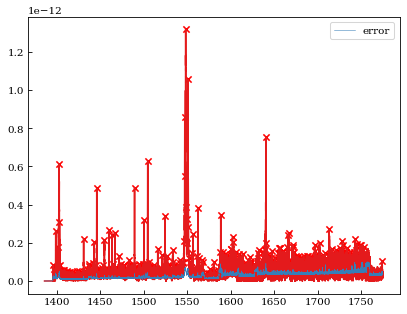

In [198]:
date_filter = all_spectra.spec_df['obsdate']=='2022-08-14'

flux = all_spectra.spec_df.loc[date_filter, 'flux'].values[0].value
fluxerr = all_spectra.spec_df.loc[date_filter, 'fluxerr'].values[0].value
wavelength = all_spectra.spec_df.loc[date_filter, 'wavelength'].values[0].value

peaks, _ = find_peaks(flux, height=fluxerr*2, distance=50)
#print(peaks)
plt.plot(wavelength, flux)
plt.scatter(wavelength[peaks], flux[peaks], c='red', marker='x')
#plt.hlines(np.mean(fluxerr[flux>0]), min(wavelength), max(wavelength), 'r','--')
plt.plot(wavelength, fluxerr, lw=0.5, label='error')
plt.legend()
#plt.xlim(left=1390)
plt.show()

In [ ]:
for _, row in stacked_df.iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.scatter(row['wavelength'][row['H2line_idx']], row['flux'][row['H2line_idx']], c='r', marker='x')
    plt.title(row['obsdate']+' '+row['filter'])
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
    plt.show()

# Now investigate individual lines

In [4]:
all_spectra.spec_df = all_spectra.spec_df[all_spectra.spec_df["[nu', J']"].notna() & (all_spectra.spec_df["[nu', J']"].apply(len) > 0)] #remove the spectra (coadded for one observation date) that don't have any H2 lines

In [5]:
line_df = all_spectra.get_lines(all_spectra.spec_df) #rearrange df by progressions, not obsdate

# Look for contaminated lines

{'[0,3]', '[2,12]', '[0,2]', '[1,7]', '[4,13]', '[0,1]', '[3,16]', '[2,15]', '[1,4]', '[3,0]', '[4,4]', '[3,13]'}

In [6]:
exclude_lines = {
    "[0,1]": {
        "dates": ["2022-08-11", "2022-08-24", "2011-07-20", "2021-08-11", "2021-08-11", "2021-08-11", "2011-07-20", "2012-02-28", "2012-02-28", "2021-08-16", "2022-08-14", "2022-08-11", "2022-08-11"],
        "wavelengths": [1460.17, 1521.59, 1521.59, 1398.95, 1460.17, 1521.59, 1398.95, 1521.59, 1398.95, 1521.59, 1521.59, 1398.95, 1521.59]
    },
    "[0,2]": {
        "dates": ["2022-06-16", "2022-08-11", "2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "2022-08-10", "2022-08-13", "All"],
        "wavelengths": [1525.15, 1463.83, 1525.15, 1402.65, 1463.83, 1525.15, 1402.65, 1525.15, 1525.15, 1525.15]
    },
    "[1,4]": {
        "dates": ["2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11"],
        "wavelengths": [1431.01, 1431.01, 1446.12, 1489.57, 1504.76]
    },
    "[1,7]": {
        "dates": ["All", "All", "2022-08-11", "2022-08-11", "2011-07-20", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "2021-08-21", "2022-08-18"],
        "wavelengths": [1556.87, 1524.65, 1467.08, 1500.45, 1556.87, 1467.08, 1500.45, 1524.65, 1556.87, 1556.87, 1556.87, 1556.87]
    },
    "[2,12]": {
        'dates': ['2021-08-10', '2021-08-18', '2021-08-18', '2022-06-16', '2022-06-16', '2022-08-1', '2022-08-11', '2022-08-11', '2021-08-20', '2011-07-20', '2021-08-11', '2021-08-11', '2021-08-11', '2012-02-28', '2021-08-16', '2021-08-12', '2022-08-10', "All", "2022-08-11", "All"],
        "wavelengths": [1453.10, 1555.89, 1588.8, 1453.1, 1555.89, 1453.1, 1555.89, 1588.8, 1555.89, 1588.8, 1453.1, 1555.89, 1588.8, 1555.89, 1453.1, 1555.89, 1453.1, 1434.54, 1453.1, 1453.1]
    },
    "[4,13]": {
        "dates": [
            "2011-07-20", "All", "2021-08-10", "2021-08-11", "2021-08-11",
            "2021-08-14", "2021-08-16", "2021-08-17", "2022-08-11", "2022-08-11",
            "2022-08-13", "2022-08-24", "2022-06-16", "All"
        ],
        "wavelengths": [
            1415.33, 1509.45, 1415.33, 1415.33, 1613.99,
            1415.33, 1415.33, 1415.33, 1415.33, 1613.99,
            1415.33, 1415.33, 1415.33, 1613.99
        ]
    },
    "[3,13]": {
        "dates": [
            "All", "2012-02-28", "2021-08-11", "2022-08-11", "2022-08-15",
            "2022-08-16", "2022-08-17", "2022-08-18", "2022-08-20", "2022-08-23",
            "2022-08-24", "2022-06-16"
        ],
        "wavelengths": [
            1615.43, 1608.33, 1608.33, 1608.33, 1608.33,
            1608.33, 1608.33, 1608.33, 1608.33, 1608.33,
            1608.33, 1608.33
        ]
    },
    "[4,4]": {
        "dates": [
            "All", "2021-08-10", "2021-08-10", "2021-08-11", "2021-08-11",
            "2021-08-15", "2021-08-21", "2022-08-11", "2022-08-11", "2022-08-15",
            "2021-08-10", "2021-08-11", "2021-08-15", "2021-08-17", "2021-08-18",
            "2022-08-11", "All"
        ],
        "wavelengths": [
            1477.05, 1526.55, 1613.72, 1526.55, 1613.72,
            1526.55, 1526.55, 1526.55, 1613.72, 1526.55,
            1477.05, 1477.05, 1477.05, 1477.05, 1477.05,
            1477.05, 1526.55
        ]
    }
}

In [7]:
# exclude bad/contaminated lines from coadding
#bad_transitions = ['[3,0]', '[4,13]', '[3,13]', '[4,4]', '[2,15]', '[3,16]', '[4,0]', '[0,3]']
bad_transitions = ['[3,0]', '[2,15]', '[3,16]', '[4,0]', '[0,3]', '[3,13]']
bad_transitions_mask = ~line_df['transition'].isin(bad_transitions)
line_df = line_df[bad_transitions_mask]

contaminated = []
for transition in exclude_lines.keys():
    dates = exclude_lines[transition]['dates']
    lines_ex = exclude_lines[transition]['wavelengths']
    for d, w in zip(dates, lines_ex):
        if d == "All":
            exclude_idx = line_df.index[(line_df['transition']==transition)&(line_df['labline']==w)].tolist()
        else:
            exclude_idx = line_df.index[(line_df['transition']==transition)&(line_df['labline']==w)&(line_df['obsdate']==d)].tolist()
        contaminated.extend(exclude_idx)

line_df = line_df.drop(index=contaminated)

line_df = line_df[line_df['obsdate']!='2021-08-11']
#Drop duplicates
line_df = line_df[~line_df.duplicated(['obsdate', 'transition', 'labline'])].reset_index(drop=True)

In [8]:
blue_transitions = {'[2,12]', '[4,13]', '[4,4]'}
mask = line_df['transition'].isin(blue_transitions)
blue_df = line_df[mask]
all_spectra.coaddwave(blue_df, columns=['labline'])

/tmp/ipykernel_69995/2650491994.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(drop_indices, inplace=True)


## Model the emission lines and save the parameters

### Fit One Gaussian

In [9]:
# labline: mask array
line_mask_dict = {
    1453.1:200,
    1555.89:[75,175],
    1463.83:200,
    1613.72:[75,200],
    1415.33:180 
}

In [10]:
fit_oneGauss(line_df, line_mask_dict)
fit_oneGauss(blue_df, line_mask_dict)

/homes/pkottapalli/GitHub/scripts_by_me/research24/astrotest/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/tmp/ipykernel_69995/2650491994.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BIC1'] = pd.Series([None] * len(df), dtype=object)
/tmp/ipykernel_69995/2650491994.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['params1'

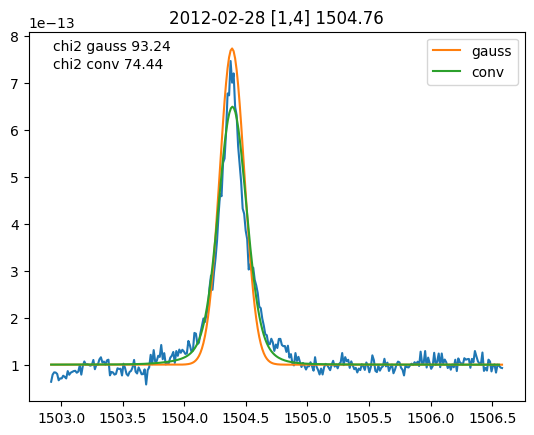

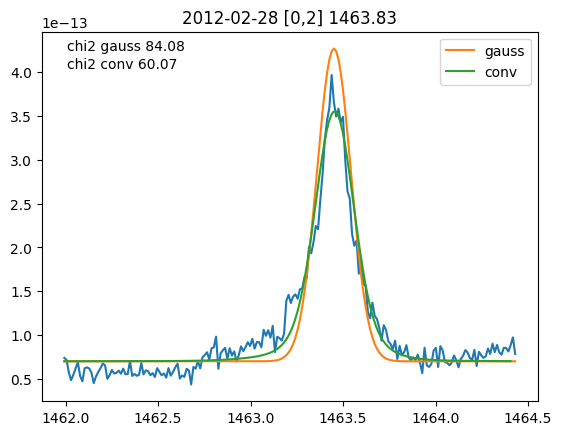

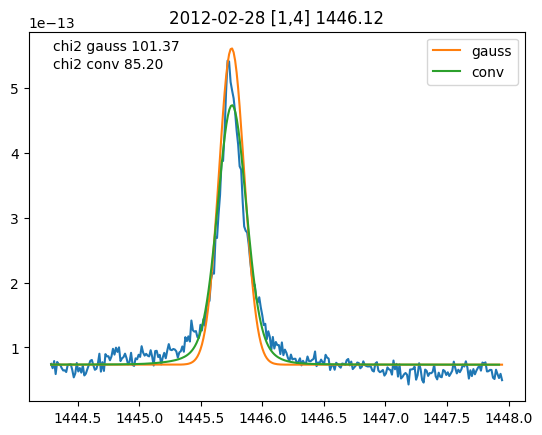

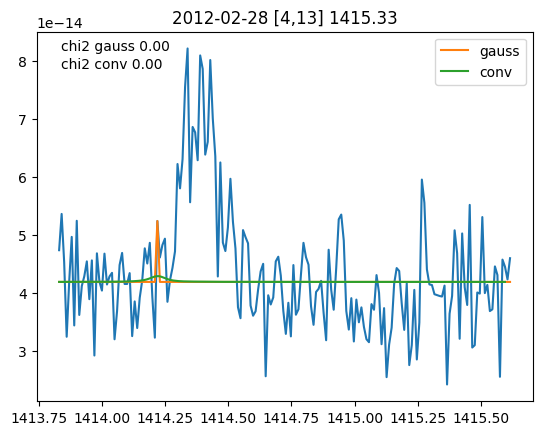

Bad error estimation in fit


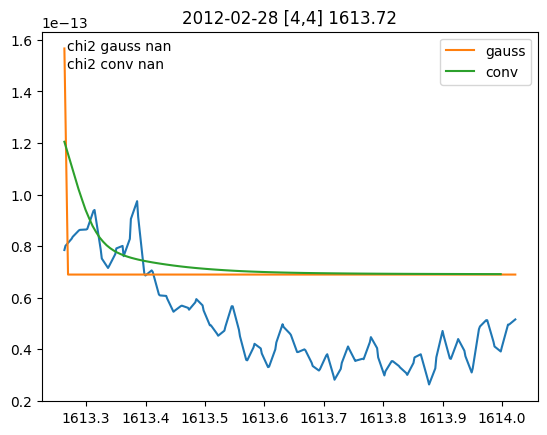

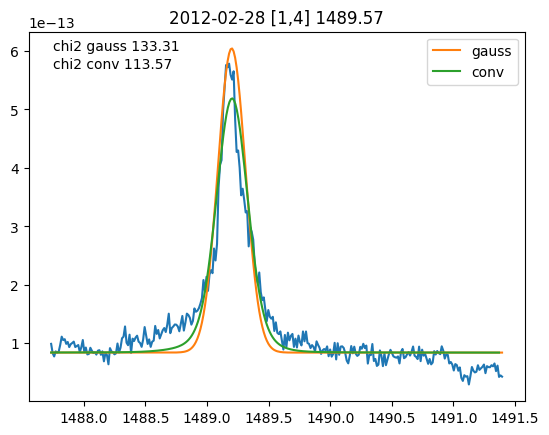

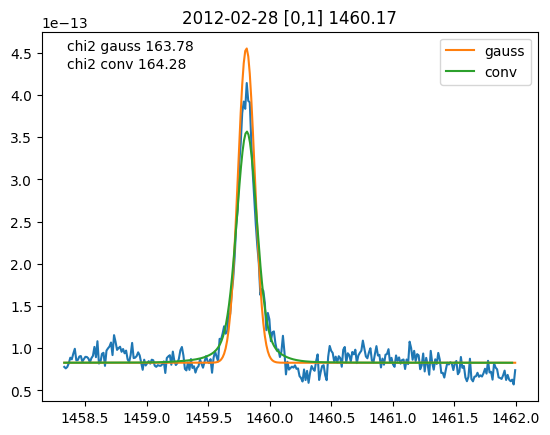

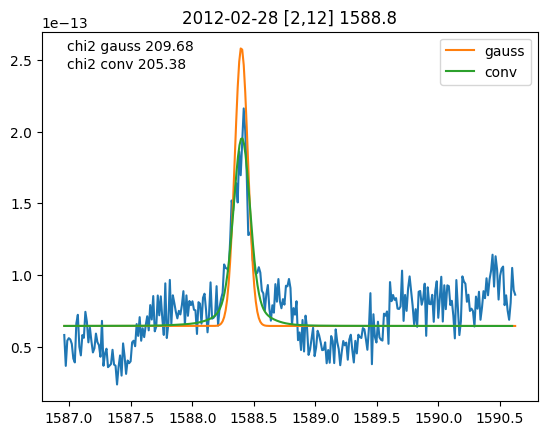

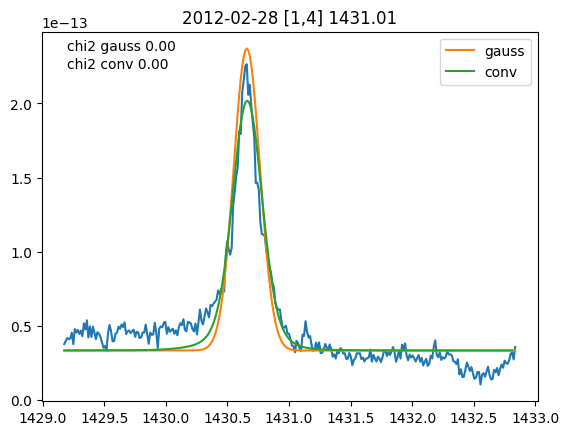

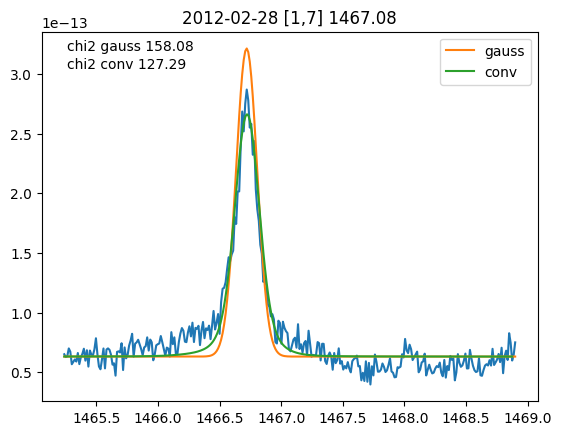

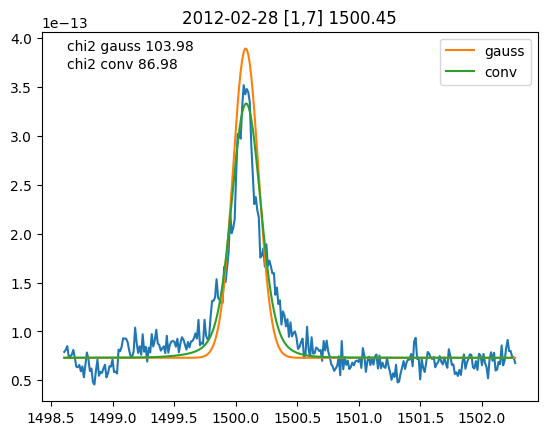

In [68]:
### Plot the fits as a test
for labline in set(line_df['labline']):
    blue_lya_mask_dict = {'labline':labline, 'obsdate': '2012-02-28'}
    unique_lines = all_spectra.mask_df(df=line_df, mask_dict=blue_lya_mask_dict)
    for i, row in unique_lines.iterrows():
        x, y, yerr = row['wavelength'].value.copy(), row['flux'].value.copy(), row['fluxerr'].copy()
        params = row['params1']
        #paramerrs = [v[1] for v in row['params1'].values()]
        if labline in line_mask_dict.keys():
            mask_idx = line_mask_dict[labline]
            if isinstance(mask_idx, list):
                mask=np.ones(300, dtype=bool)
                mask[mask_idx[0]:mask_idx[1]] = False
            else:
                mask=np.zeros(300, dtype=bool)
                mask[mask_idx:] = True
            x = x[~mask]
            y = y[~mask]
            yerr = yerr[~mask]
        xgauss = np.linspace(np.nanmin(x), np.nanmax(x), len(x))
        ygauss = gaussian(xgauss, params['amp'][0], params['sig'][0], params['cen'][0], params['bgl'][0])
        try:
            yerrgauss = gauss_err(params)
        except TypeError:
            yerrgauss=[None]*len(x)
            print("Bad error estimation in fit")
        xconv, yconv, yerr = convolve_lsf(xgauss, ygauss, yerrgauss, row['LSFfile'], row['dispfile'], row['cenwave'], row['filter'], row['segment'])
        redchi2_gauss = np.sum((ygauss[~np.isnan(y)]-y[~np.isnan(y)])**2/yerr[~np.isnan(y)]**2)/len(y[~np.isnan(y)])
        redchi2_conv = np.sum((yconv[~np.isnan(y)]-y[~np.isnan(y)])**2/yerr[~np.isnan(y)]**2)/len(y[~np.isnan(y)])
        plt.plot(x, y)
        plt.plot(xgauss, ygauss, label='gauss')
        plt.plot(xconv, yconv, label='conv')
        plt.text(0.05, 0.95, f"chi2 gauss {redchi2_gauss:0.2f}", transform=plt.gca().transAxes)
        plt.text(0.05, 0.90, f"chi2 conv {redchi2_conv:0.2f}", transform=plt.gca().transAxes)
        plt.title(f"{row['obsdate']} {row['transition']} {row['labline']}")
        plt.legend()
        plt.show()

### Fit double Gaussian

In [20]:
fit_twoGauss(line_df, line_mask_dict)
fit_twoGauss(blue_df, line_mask_dict)

/homes/pkottapalli/GitHub/scripts_by_me/research24/astrotest/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[1.28553548

/tmp/ipykernel_69995/194606640.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BIC2'] = pd.Series([None] * len(df), dtype=object)
/tmp/ipykernel_69995/194606640.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['params2'] = pd.Series([None] * len(df), dtype=object)
/homes/pkottapalli/GitHub/scripts_by_me/research24/astrotest/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects wit

125
masking
list mask
Bad error estimation in fit
125 125 125


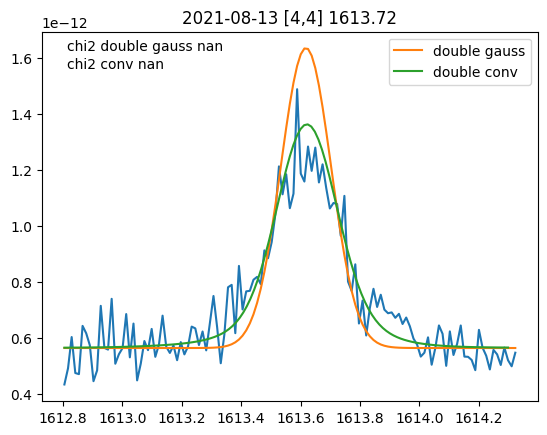

180
masking
one mask
180 180 180


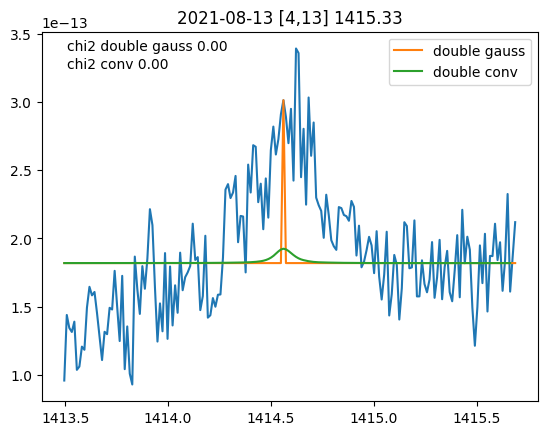

100
masking
list mask
Bad error estimation in fit
100 100 100


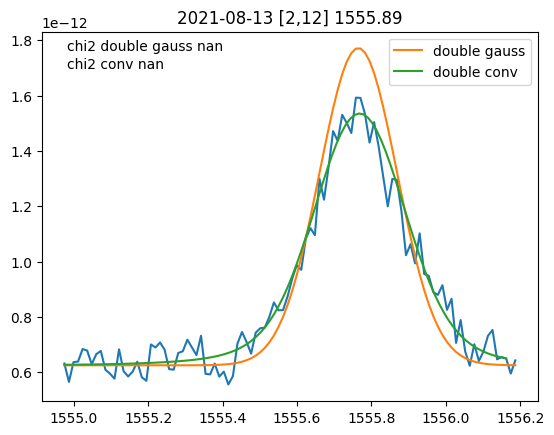

300
300 300 300


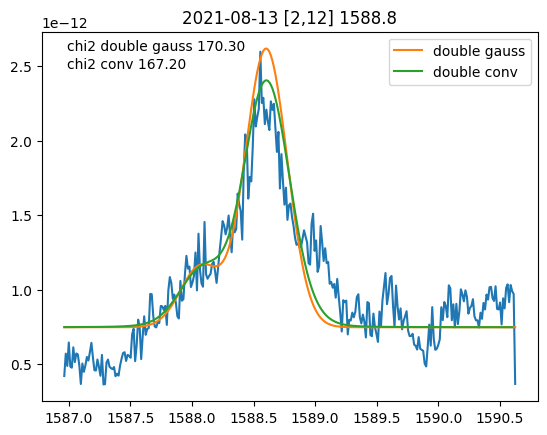

In [ ]:
# for labline in set(line_df['labline']):
#     blue_lya_mask_dict = {'labline':labline, 'obsdate': '2012-02-28'}
#     unique_lines = all_spectra.mask_df(df=line_df, mask_dict=blue_lya_mask_dict)
    # for i, row in unique_lines.iterrows():
for i, row in blue_df.iterrows():
    x, y, yerr = row['wavelength'].value.copy(), row['flux'].value.copy(), row['fluxerr'].value.copy()
    #params = row['params1']
    params2 = row['params2']
    labline = row['labline']
    print(len(params2['wavelength']))
    if labline in line_mask_dict.keys():
        print('masking')
        mask_idx = line_mask_dict[labline]
        if isinstance(mask_idx, list):
                print('list mask')
                mask=np.ones(300, dtype=bool)
                mask[mask_idx[0]:mask_idx[1]] = False
        else:
            print('one mask')
            mask=np.zeros(300, dtype=bool)
            mask[mask_idx:] = True
        x = x[~mask]
        y = y[~mask]
        yerr = yerr[~mask]
    x2gauss = np.linspace(np.nanmin(x), np.nanmax(x), len(x))
    y2gauss = double_gauss(x2gauss, params2['amp1'][0], params2['sig1'][0], params2['cen1'][0], params2['amp2'][0], params2['sig2'][0], params2['cen2'][0], params2['bgl'][0])
    try:
        yerr2gauss = double_gauss_err(params2)
    except TypeError:
        yerr2gauss=[None]*len(x)
        print("Bad error estimation in fit")
    x2conv, y2conv, y2err = convolve_lsf(x2gauss, y2gauss, yerr2gauss, row['LSFfile'], row['dispfile'], row['cenwave'], row['filter'], row['segment'])
    redchi2_gauss = np.sum((y2gauss[~np.isnan(y)]-y[~np.isnan(y)])**2/y2err[~np.isnan(y)]**2)/len(y[~np.isnan(y)])
    redchi2_conv = np.sum((y2conv[~np.isnan(y)]-y[~np.isnan(y)])**2/y2err[~np.isnan(y)]**2)/len(y[~np.isnan(y)])
    plt.plot(x, y)
    plt.plot(x2gauss, y2gauss, label='double gauss')
    plt.plot(x2conv, y2conv, label='double conv')
    plt.text(0.05, 0.95, f"chi2 double gauss {redchi2_gauss:0.2f}", transform=plt.gca().transAxes)
    plt.text(0.05, 0.90, f"chi2 conv {redchi2_conv:0.2f}", transform=plt.gca().transAxes)
    plt.title(f"{row['obsdate']} {row['transition']} {row['labline']}")
    plt.legend()
    plt.show()

In [28]:
line_df['BIC1']-line_df['BIC2']

0      -6.175423
1      24.922761
2       1.067365
3     -14.389812
4       1.704538
         ...    
311     5.396346
312    26.517592
313     30.36663
314    70.169298
315    11.984847
Length: 316, dtype: object

# Coadd lines in velocity space

In [ ]:
columns = ['transition', 'obsdate']
combinations = line_df[columns].drop_duplicates()
drop_indices = []
for _, row in combinations.iterrows():
    unique_values = [row[col] for col in columns]
    # Filter the group
    mask = np.logical_and.reduce([(line_df[col] == val) for col, val in zip(columns, unique_values)])
    group = line_df[mask]
    
    coadded_singleflux = 0
    template1v = group['params1'].iloc[0]['velocity']
    coadd_singleerror = 0

    coadded_doubleflux = 0
    template2v = group['params2'].iloc[0]['velocity']
    coadd_doubleerror = 0
    
    for _, row in group.iterrows():
        #Coadd both Gaussians
        params = row['params1']
        params2 = row['params2']
        single_flux = gaussian(params['wavelength'].value, params['amp'][0], params['sig'][0], params['cen'][0], params['bgl'][0])
        try:
            single_fluxerr = gauss_err(params)
        except TypeError:
            single_fluxerr = double_fluxerr = [1e-17]*len(single_flux)
        double_flux = double_gauss(params2['wavelength'].value, params2['amp1'][0], params2['sig1'][0], params2['cen1'][0], params2['amp2'][0], params2['sig2'][0], params2['cen2'][0], params2['bgl'][0])
        try:
            double_fluxerr = double_gauss_err(params2)
        except TypeError:
            double_fluxerr = [1e-17]*len(double_flux)
        resampled_singleflux = np.interp(template1v, params['velocity'], single_flux)
        resampled_singlefluxerr = np.interp(template1v, params['velocity'], single_fluxerr)
        resampled_doubleflux = np.interp(template2v, params['velocity'], double_flux)
        resampled_doublefluxerr = np.interp(template2v, params['velocity'], double_fluxerr)
        coadded_singleflux += resampled_singleflux
        coadd_singleerror += (resampled_singlefluxerr)**2
        coadded_doubleflux += resampled_doubleflux
        coadd_doubleerror += (resampled_doublefluxerr)**2

    N = len(group)
    coadded_singleflux = coadded_singleflux/N
    coadded_singleerror = np.sqrt(coadd_singleerror)/np.sqrt(N)
    first_index = group.index[0]
    # All the first index properties are inherited and the rest is dropped
    df.at[first_index, 'flux'] = coadded_flux*self.flux_units
    df.at[first_index, 'fluxerr'] = coadded_error*self.flux_units
    drop_indices.extend(group.index[1:])

# df.drop(drop_indices, inplace=True)
# df.reset_index(inplace=True, drop=True)
#return prog_df
#Re-calculate 

In [134]:
prog_df = line_df.copy()
all_spectra.coaddvel(prog_df, columns=['transition', 'obsdate'])

## Plot coadded lines

In [ ]:
#ibm_colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
for transition_plot in ['[1,4]']:# prog_df['transition'].unique():
#for transition_plot in ['[1,7]']:
    mask = prog_df['transition']==transition_plot

    for _, row_prog in prog_df[mask].iterrows():
        fig, ax = plt.subplots(1,2, figsize=(7,3))
        fig.suptitle(row_prog['obsdate']+' '+transition_plot)
        coadd_lines = line_df[(line_df['transition']==transition_plot) & (line_df['obsdate']==row_prog['obsdate'])]
        for _, row_line in coadd_lines.iterrows():
            velocity = all_spectra.radial_velocity(row_line['wavelength'], row_line['labline'])
            ax[0].plot(velocity, row_line['flux'], alpha=0.4, label=row_line['labline'])
            ax[1].plot(velocity, row_line['flux']/row_line['fluxerr'], alpha=0.4, label=row_line['labline'])

            
        ax[0].plot(row_prog['velocity'], row_prog['flux'], c='black', ls='--', label='coadd')
        ax[0].vlines(0, 0,1.3e-13, 'r')

        ax[1].plot(row_prog['velocity'], row_prog['flux'].value/row_prog['fluxerr'].value, c='black', ls='--', label='coadd')
        
        ax[0].set_xlabel('Radial Velocity'+' '+u.format.Latex().to_string(row_prog['velocity'].unit, fraction=False))
        ax[1].set_xlabel('Radial Velocity'+' '+u.format.Latex().to_string(row_prog['velocity'].unit, fraction=False))
        
        ax[0].set_ylabel('Flux'+' '+u.format.Latex().to_string(row_prog['flux'].unit, fraction=False))
        ax[0].text(0.05, 0.95, f'Num lines = {len(coadd_lines)}', transform=plt.gca().transAxes, verticalalignment='top')
        ax[0].set_ylim(0, 3e-13)
        ax[0].set_xlim(-300,300)
        ax[0].legend(loc='lower right')
        ax[0].set_title('Coadded Spectral Line')
        ax[1].set_title('SNR')
        plt.show()

# Time-series plots of parameters and integrated fluxes

In [ ]:
def integrated_flux(fluxes):
    return np.sum(fluxes)

int_fluxes = prog_df['flux'].map(lambda x: np.sum(x)/all_spectra.flux_units)
for transition_plot in prog_df['transition'].unique():
    mask = prog_df['transition'] == transition_plot
    x = prog_df['obsdate'][mask]
    y = int_fluxes[mask]
    plt.plot(x, y)
    plt.ylabel('Integrated flux')
    plt.xlabel('Date')
    plt.title(transition_plot)
    plt.gca().tick_params(axis='x', labelrotation=60, labelsize=8)
    plt.show()

In [ ]:
def fitParamPlot(transition):
    dates = list(fit_dict[transition].keys())
    fig, axs = plt.subplots(1, len(fit_keys), figsize=(17,5), layout='tight')
    for i, param in enumerate(fit_keys):
        y = [fit_dict[transition][date][param][0] for date in dates]
        yerr = [fit_dict[transition][date][param][1] for date in dates]
        yerr = [np.nan if err==None else err for err in yerr]
        axs[i].errorbar(dates, y, yerr=yerr, fmt='o', marker='.', ecolor='gray')
        axs[i].set_title(param)
        axs[i].set_ylabel(param)
        axs[i].tick_params(axis='x', labelrotation=60, labelsize=8)
        if param == 'amp' or param == 'sig' or param == 'cen':
            axs[i].set_ylim(.3*min(y), 1.3*max(y))

    fig.suptitle(f'Parameters timeseries for {transition}')
    fig.supxlabel('Dates')
    fig.show()

for transition_plot in fit_dict.keys():
    fitParamPlot(transition_plot)

# Search for asymmetry by mirroring diff

Should reflect along the peak of flux

In [ ]:
cmap = matplotlib.pyplot.get_cmap('seismic', lut=len(prog_df['transition'].unique()))
clrs = []
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    clrs.append(matplotlib.colors.rgb2hex(rgba))
ordered_transitions = ['[3,13]', '[4,13]', '[4,4]', '[1,7]', '[1,4]', '[0,1]', '[0,2]', '[2,12]']
lya_colors = dict(zip(ordered_transitions, clrs))

for date in prog_df['obsdate'].unique():
    fig, ax = plt.subplots()
    offset = 1#e-13
    prog_df['transition'] = pd.Categorical(prog_df['transition'], categories=ordered_transitions, ordered=True)
    prog_from_date = prog_df[prog_df['obsdate']==date].sort_values(by='transition', ignore_index=True)
    for i, row_mirror in prog_from_date.iterrows():
        vel_arr = row_mirror['velocity']
        flux_arr = row_mirror['flux']
        flux_arr = flux_arr/np.max(flux_arr) #normalize the flux array
        mirrored_vel = 2 * vel_arr[np.argmax(flux_arr[125:175])] - vel_arr #mirror the velocity array along the maximum flux value found in the center of the plot
        sorted_indices = np.argsort(mirrored_vel)
        mirrored_flux = flux_arr.copy()
        x_mirrored = mirrored_vel[sorted_indices]
        y_mirrored = mirrored_flux[sorted_indices]
        residuals_x = vel_arr
        residuals_y = flux_arr - y_mirrored
        ax.plot(residuals_x, residuals_y.value - i*offset, label=row_mirror['transition'], c=lya_colors[row_mirror['transition']])
        ax.set_xlabel('Radial Velocity'+' ('+u.format.Latex().to_string(row_mirror['velocity'].unit, fraction=False)+')')
        ax.set_ylabel('Normalized Flux'+' ('+u.format.Latex().to_string(row_mirror['flux'].unit, fraction=False)+')')
        ax.set_title(row_mirror['obsdate'])
    ax.legend()
    plt.show()